In [1]:
from intercode import AutoencoderLinearDecoder, train_autoencoder

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['figure.dpi'] = 100

import torch
import torch.nn as nn
import scanpy as sc
import numpy as np

In [6]:
# preprocessed Kang18 dataset (log transformed, highly variable genes) 
# with reactome annotations in adata.varm['I']
# download dataset - https://drive.google.com/open?id=1-N7wPpYUf_QcG5566WVZlaxVC90M7NNE
adata = sc.read('kang_count.h5ad')

In [7]:
select_genes = adata.varm['I'].sum(1)>0
adata._inplace_subset_var(select_genes)
adata.X-=adata.X.mean(0)

In [79]:
LR = 0.001
BATCH_SIZE = 62
N_EPOCHS = 30

# regularization hyperparameters
# lambda0 - page 19 of presentation
# lambdas 1-3 - last term on page 20

LAMBDA0 = 0.1

LAMBDA1 = 0.93*LR
#LAMBDA2 = 0.43*LR
LAMBDA3 = 0.57*LR

In [80]:
autoencoder = AutoencoderLinearDecoder(adata.n_vars, n_ann=len(adata.uns['terms']))
# autoencoder = AutoencoderLinearDecoder(adata.n_vars, n_ann=len(adata.uns['terms']), n_sparse=3)
# n_vars - number of genes in the dataset
# n_ann - number of annotated terms, corresponding l1 regularization hyperparameter - lambda1
# n_sparse - number of sparse terms, corresponding l1 regularization hyperparameter - lambda2
# n_dense - number of dense terms

In [81]:
train_autoencoder(adata, autoencoder, LR, BATCH_SIZE, N_EPOCHS,
                  l2_reg_lambda0=LAMBDA0, lambda1=LAMBDA1, lambda2=LAMBDA2, lambda3=LAMBDA3)

Epoch: 0 | batch train loss: 350.2841
Epoch: 0 | batch train loss: 82.3557
Epoch: 0 | batch train loss: 72.3049
Epoch: 0 -- total train loss:  61.6031=57.1806+4.4225
Number of deactivated terms: 0
Share of deactivated inactive genes: 0.9752
Epoch: 1 | batch train loss: 61.6889
Epoch: 1 | batch train loss: 54.7027
Epoch: 1 | batch train loss: 61.0922
Epoch: 1 -- total train loss:  56.5140=52.5846+3.9293
Number of deactivated terms: 1
Share of deactivated inactive genes: 0.9921
Epoch: 2 | batch train loss: 55.5572
Epoch: 2 | batch train loss: 58.7912
Epoch: 2 | batch train loss: 53.2301
Epoch: 2 -- total train loss:  52.0661=47.4958+4.5703
Number of deactivated terms: 23
Share of deactivated inactive genes: 0.9934
Epoch: 3 | batch train loss: 52.8497
Epoch: 3 | batch train loss: 55.3023
Epoch: 3 | batch train loss: 46.5333
Epoch: 3 -- total train loss:  49.3828=44.5681+4.8148
Number of deactivated terms: 26
Share of deactivated inactive genes: 0.9952
Epoch: 4 | batch train loss: 63.7872


In [82]:
autoencoder.decoder.weight_dict['annotated'].data.norm(p=2, dim=0)

tensor([1.3634, 1.1701, 0.0000, 1.0368, 1.0235, 1.4182, 0.9784, 1.2357, 0.0000,
        1.1396, 1.7313, 1.2213, 1.5495, 1.1573, 0.0000, 1.0275, 0.0000, 0.0000,
        0.0000, 0.6013, 0.0000, 0.9223, 1.3081, 0.9982, 0.0000, 0.9669, 0.0000,
        0.0000, 1.3362, 0.0000, 1.0126, 1.0474, 1.3157, 1.2916, 0.0000, 1.2977,
        1.5209, 0.9000, 0.0000, 0.0000, 0.0000, 0.0000, 1.6826, 1.5352, 1.4424,
        1.0834, 1.1949, 0.0000, 1.2216, 0.0000, 0.4731, 1.2000, 1.3612, 1.1397,
        0.0000, 1.3290, 1.5626, 1.0904, 0.0000, 0.0000, 1.0433, 1.1168, 1.3542,
        1.1892, 1.3201, 0.0000, 1.2620, 0.0000, 0.0000, 1.1517, 1.3884, 1.0546,
        1.0498, 0.0000, 1.0240, 0.0000, 1.5636, 1.5583, 0.0000, 0.0000, 1.0888,
        0.0000, 1.5610, 0.0707, 0.0000, 0.0000, 0.0000, 1.2317, 1.0087, 1.0769,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.2544, 0.0000, 1.1369, 0.9361,
        1.8669, 1.0684, 1.0065, 1.0842, 0.0000, 1.0525, 1.4876, 0.0000, 1.0015,
        1.2786, 2.0416, 1.0823, 1.0896, 

In [83]:
autoencoder.decoder.weight_dict['sparse'].data.norm(p=2, dim=0)

tensor([0.7032, 0.6723, 0.4683])

In [84]:
(autoencoder.decoder.weight_dict['sparse'].data.abs()>0).float().sum(dim=0)

tensor([332., 304., 277.])

In [85]:
def select_terms(first, second):
    f = np.where(adata.uns['terms']==first)[0][0]
    s = np.where(adata.uns['terms']==second)[0][0]
    return f, s

In [86]:
terms = select_terms('INTERFERON_SIGNALING', 'INTERFERON_GAMMA_SIGNALING')

In [87]:
W = autoencoder.decoder.weight_dict['annotated'].data.numpy()
(np.abs(W[:, terms])>0).sum(0)

array([67, 39])

In [88]:
autoencoder.decoder.weight_dict['annotated'].data.norm(p=2, dim=0)[list(terms)]

tensor([1.8669, 1.1369])

In [89]:
adata.varm['I'][:, terms].sum(0)

array([60, 32])

In [90]:
encoded, decoded = autoencoder(torch.from_numpy(adata.X))
vars_latent = encoded[:, terms].data.numpy()

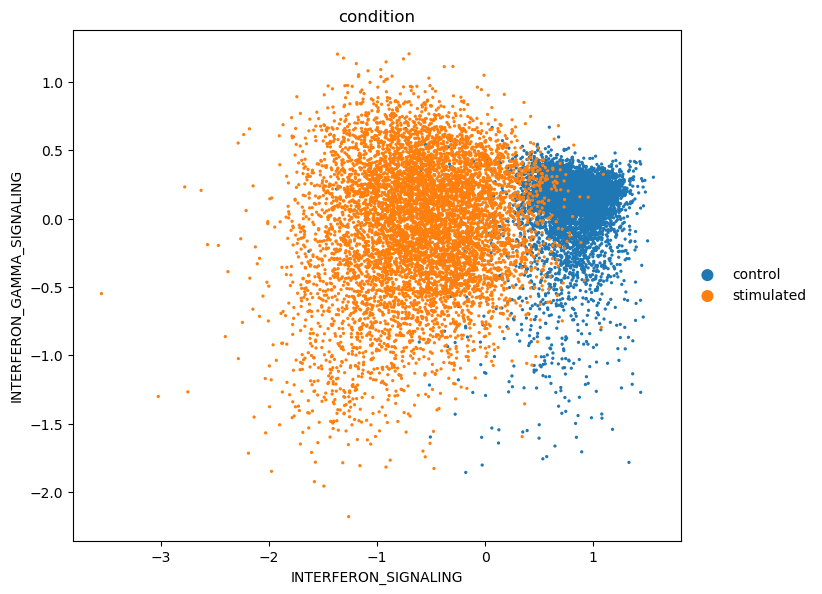

In [91]:
adata.obs['INTERFERON_SIGNALING'] = vars_latent[:, 0]
adata.obs['INTERFERON_GAMMA_SIGNALING'] = vars_latent[:, 1]
adata.obsm['X_latent'] = encoded.data.numpy()
sc.pl.scatter(adata, x='INTERFERON_SIGNALING', y='INTERFERON_GAMMA_SIGNALING', color='condition', size=22)